Trial 30 Complete [00h 00m 23s]
val_loss: 0.007537527475506067

Best val_loss So Far: 0.0007252900395542383
Total elapsed time: 00h 05m 46s
INFO:tensorflow:Oracle triggered exit
🔧 En iyi hiperparametreler:
units_1: 96
units_2: 96
dropout_1: 0.1
dropout_2: 0.2
optimizer: adam
Epoch 1/50
81/81 [==============================] - 3s 21ms/step - loss: 8.5444e-04 - val_loss: 0.1234
Epoch 2/50
81/81 [==============================] - 1s 13ms/step - loss: 8.0554e-05 - val_loss: 0.0051
Epoch 3/50
81/81 [==============================] - 1s 13ms/step - loss: 5.1108e-05 - val_loss: 0.0047
Epoch 4/50
81/81 [==============================] - 1s 13ms/step - loss: 3.9309e-05 - val_loss: 0.0049
Epoch 5/50
81/81 [==============================] - 1s 13ms/step - loss: 3.4197e-05 - val_loss: 0.0040
Epoch 6/50
81/81 [==============================] - 1s 13ms/step - loss: 3.9757e-05 - val_loss: 0.0026
Epoch 7/50
81/81 [==============================] - 1s 13ms/step - loss: 2.2925e-05 - val_loss: 0.0022
Epo

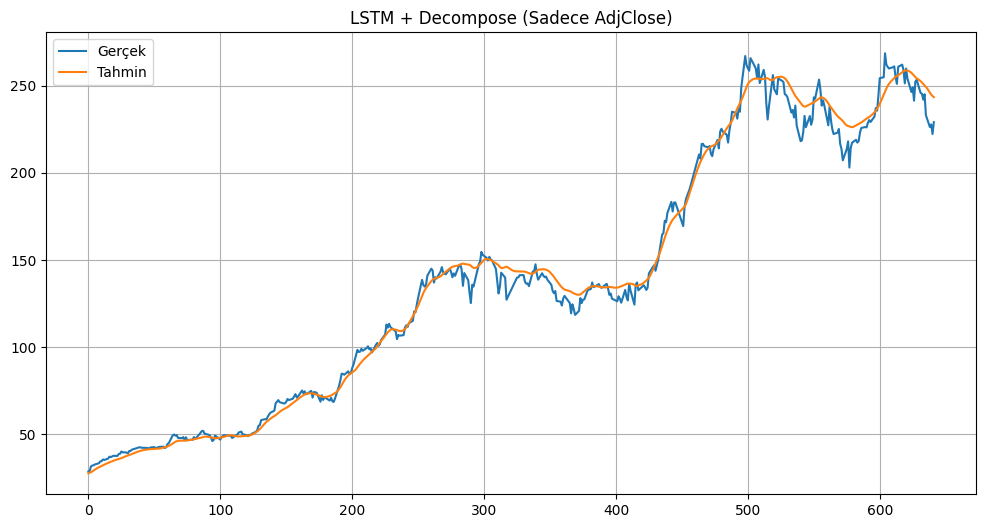

C:\Users\onugu\AppData\Local\Temp\ipykernel_30024\3857058609.py:125: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last6m = data.last('6M')
C:\Users\onugu\AppData\Local\Temp\ipykernel_30024\3857058609.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last6m = data.last('6M')


📸 Grafik kaydedildi: plots/LSTM_Decompose_last6M_2025-04-06_08-30-41.png


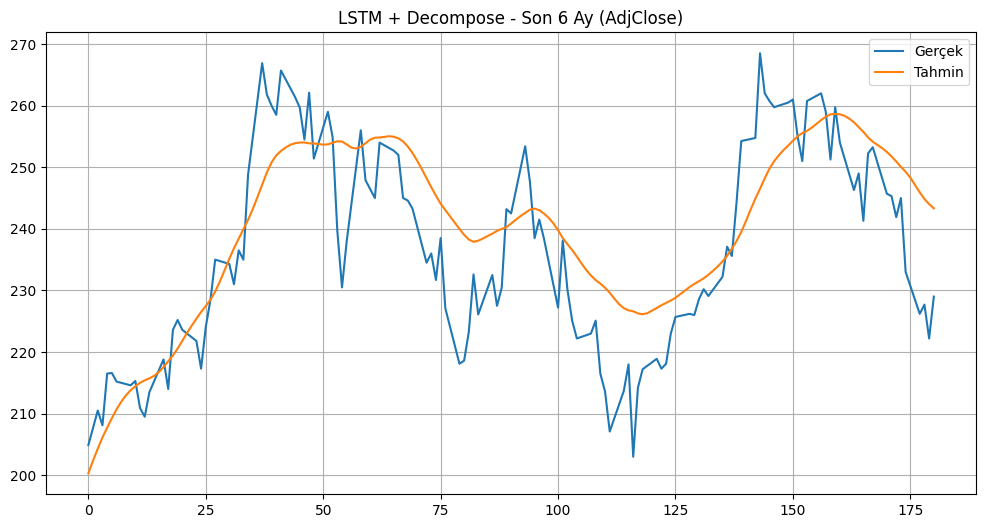

21/21 [==============================] - 0s 6ms/step

📊 Özellik Önem Sıralaması (Permutation Importance):
trend: Önem Skoru = 0.369178
resid: Önem Skoru = 0.002733
seasonal: Önem Skoru = 0.000482


In [1]:
# %%
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import copy
from statsmodels.tsa.seasonal import seasonal_decompose
from log_record import log_model_report, save_plot

# %%
print("\U0001F4E6 TensorFlow:", tf.__version__)
print("\U0001F9E0 GPU:", tf.test.gpu_device_name())

# %%
data = pd.read_csv("Merged_Data.csv", parse_dates=['Tarih'], index_col='Tarih', sep=',', decimal='.')
data = data.drop(columns=["Hacim", "Fark%", "GDP"], errors='ignore')
data.dropna(inplace=True)

# %%
decomposed = seasonal_decompose(data['AdjClose'], model='additive', period=30)
data['trend'] = decomposed.trend
data['seasonal'] = decomposed.seasonal
data['resid'] = decomposed.resid
data.dropna(inplace=True)

feature_names = ['trend', 'seasonal', 'resid']
X_all = data[feature_names].values
y_all = data[['AdjClose']].values

# %%
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all)

# %%
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# %%
window_size = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# %%
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# %%
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', 32, 128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', 32, 128, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# %%
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_logs',
    project_name='lstm_decomposed_adjclose'
)

# %%
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             verbose=1)

# %%
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\U0001F527 En iyi hiperparametreler:")
for param in ['units_1', 'units_2', 'dropout_1', 'dropout_2', 'optimizer']:
    print(f"{param}: {best_hps.get(param)}")

# %%
final_model = Sequential()
final_model.add(LSTM(units=best_hps.get('units_1'), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(best_hps.get('dropout_1')))
final_model.add(LSTM(units=best_hps.get('units_2'), return_sequences=False))
final_model.add(Dropout(best_hps.get('dropout_2')))
final_model.add(Dense(1))
final_model.compile(optimizer=best_hps.get('optimizer'), loss='mean_squared_error')

# %%
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = final_model.fit(X_train, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stop], verbose=1)

# %%
y_pred_scaled = final_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# %%
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek')
plt.plot(y_pred, label='Tahmin')
plt.title('LSTM + Decompose (Sadece AdjClose)')
plt.legend()
plt.grid(True)
save_plot("LSTM_Decompose_result")
plt.show()

# %%
last6m = data.last('6M')
last_n = len(last6m)
y_test_last6m = y_test_inv[-last_n:]
y_pred_last6m = y_pred[-last_n:]

plt.figure(figsize=(12, 6))
plt.plot(y_test_last6m, label='Gerçek')
plt.plot(y_pred_last6m, label='Tahmin')
plt.title('LSTM + Decompose - Son 6 Ay (AdjClose)')
plt.legend()
plt.grid(True)
save_plot("LSTM_Decompose_last6M")
plt.show()

# %%
baseline_pred = final_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
feature_importances = []

for i in range(X_test.shape[2]):
    X_test_copy = copy.deepcopy(X_test)
    np.random.shuffle(X_test_copy[:, :, i])
    shuffled_pred = final_model.predict(X_test_copy)
    shuffled_rmse = np.sqrt(mean_squared_error(y_test, shuffled_pred))
    importance = shuffled_rmse - baseline_rmse
    feature_importances.append((feature_names[i], importance))

feature_importances.sort(key=lambda x: x[1], reverse=True)
print("\n\U0001F4CA Özellik Önem Sıralaması (Permutation Importance):")
for feat, imp in feature_importances:
    print(f"{feat}: Önem Skoru = {imp:.6f}")

# %%
model_name = "LSTM_decomposed"
param_count = final_model.count_params()
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100
log_model_report(
    model_name=model_name,
    window_size=window_size,
    feature_names=feature_names,
    units_1=best_hps.get('units_1'),
    units_2=best_hps.get('units_2'),
    dropout_1=best_hps.get('dropout_1'),
    dropout_2=best_hps.get('dropout_2'),
    optimizer=best_hps.get('optimizer'),
    param_count=param_count,
    rmse=rmse,
    mape=mape,
    feature_importances=feature_importances
)
